In [44]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [45]:
orig = np.asarray(Image.open('disk4.bmp'))
img = np.asarray(Image.open('disk4_with_points.bmp'))
print(img.shape)
print(orig.shape)

# organization is y, x, [r, g, b, a]

(973, 972, 4)
(973, 972, 4)


In [46]:
from numpy import sqrt


def get_all_blue(img):
    points = set()
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            v = img[y][x]
            if v[0] == 0 and v[1] == 0 and v[2] == 0xff:
                points.add((y, x))
    return points

blue = get_all_blue(img)
print(len(blue))



1200


48


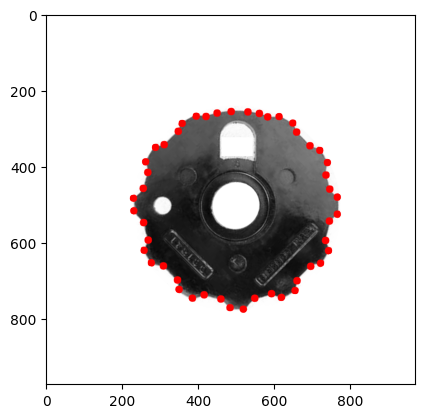

In [47]:
def dist(pt1, pt2):
    y1, x1 = pt1
    y2, x2 = pt2
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def pt_center(pts):
    sy, sx = 0, 0
    for y, x in pts:
        sy += y
        sx += x

    return int(sy/(len(pts))), int(sx/(len(pts)))

def get_points(blue, d=10):
    parts = []
    for pt in blue:
        found_part = False
        for part in parts:
            if dist(pt, part[0]) <= d:
                part.append(pt)
                found_part = True
                break
        if not found_part:
            parts.append([pt])
    return [pt_center(part) for part in parts]

points = get_points(blue)
print(len(points))

def neighbors(pt, d):
    cy, cx = pt
    ret = set()
    for x in range(cx-d, cx+d+1):
        for y in range(cy-d, cy+d+1):
            if dist(pt, (y, x)) <= d:
                ret.add((y, x))
    return ret

def set_neighbors(img, pt, d, v):
    for (y, x) in neighbors(pt, d):
        img[y][x] = v

def with_red_blobs(img, pts):
    img = img.copy()
    for pt in pts:
        set_neighbors(img, pt, 10, [0xff, 0, 0, 0xff])
    return img

plt.imshow(with_red_blobs(img, points))

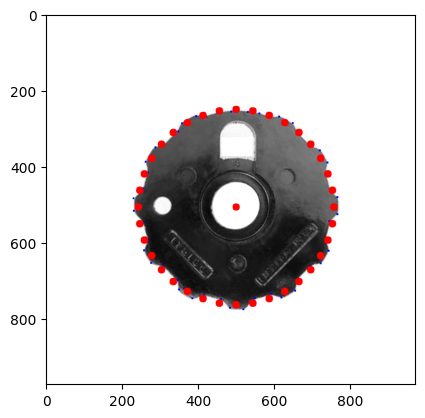

In [48]:
import math
import scipy.optimize

center_guess = pt_center(points)

def circle_cost(circle, points):
    cy, cx, r = circle
    center = (cy, cx)
    total_cost = 0
    for pt in points:
        d = dist(pt, center)
        total_cost += (d - r) ** 2
    return total_cost / len(points)

circle_guess = [center_guess[0], center_guess[1], 200.0]
res = scipy.optimize.minimize(circle_cost, circle_guess, args=(points,))

center = (int(res.x[0]), int(res.x[1]))
r = res.x[2]


def cart_rel(c, pt):
    d, a = pt
    y = math.sin(a) * d
    x = math.cos(a) * d

    return (int(y) + c[0], int(x) + c[1])


circle_points = [cart_rel(center, (r, math.radians(a))) for a in range(0, 360, 10)]

plt.imshow(with_red_blobs(img, [center] + circle_points))

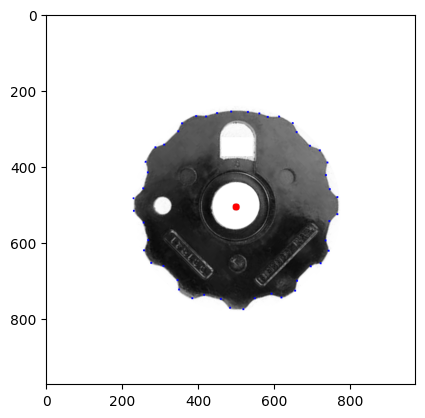

In [49]:
plt.imshow(with_red_blobs(img, [center]))

3780.0


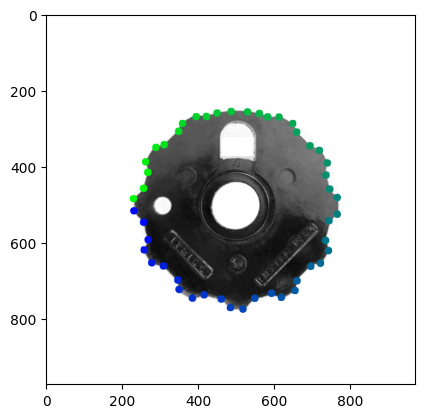

In [50]:
import math

def angle(c, pt):
    cy, cx = c
    y, x = pt

    y -= cy
    x -= cx

    return np.arctan2(y, x)

def polar_rel(c, pt):
    return (dist(c, pt), angle(c, pt))

def cart_rel(c, pt):
    d, a = pt
    y = math.sin(a) * d
    x = math.cos(a) * d

    return (int(y) + c[0], int(x) + c[1])

polar_points = sorted([polar_rel(center, pt) for pt in points], key=lambda pt: pt[1])

cart_points = [cart_rel(center, pt) for pt in polar_points]

def interpolate(start, end, ratio):
    return [int((1-ratio) * s + ratio * e)  for (s, e) in zip(start, end)]

def with_blobs(img, pts, start_color, end_color):
    img = img.copy()
    start = start_color
    end = end_color
    for i, pt in enumerate(pts):
        ratio = i / len(pts)
        v = interpolate(start, end, ratio)
        set_neighbors(img, pt, 10, v)
    return img


test_pt = (300, 0 + 21 * math.pi)

print(math.degrees(test_pt[1]))


# plt.imshow(with_red_blobs(img, [cart_rel(center, test_pt)]))
plt.imshow(with_blobs(img, cart_points, [0, 0xff, 0, 0xff], [0, 0, 0xff, 0xff]))
# plt.imshow(img.copy())

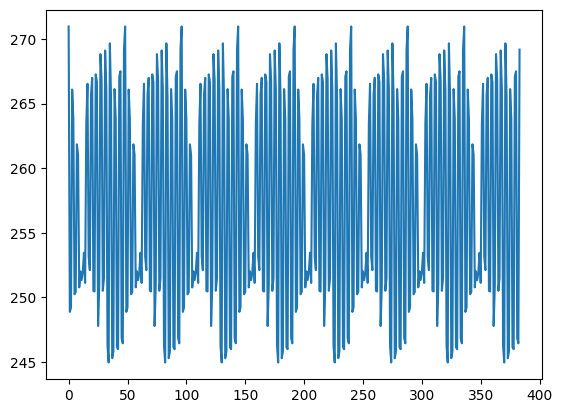

In [51]:
xs = [p[1] for p in polar_points]
ys = [p[0] for p in polar_points]

for _ in range(3):
    xs.extend(xs)
    ys.extend(ys)

plt.plot(ys)

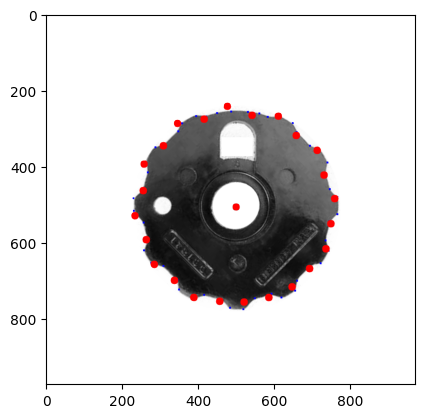

In [54]:
# find needle positions. They should be 10 degree arcs. Then 5 degree of spacing.

polar_points_degrees = [(d, math.degrees(a) + 180) for (d, a) in polar_points]

def needle_position(points, angle):
    for i in range(len(points)):
        ni = i+1
        if ni == len(points):
            ni = 0

        a = points[i][1]
        na = points[ni][1]
        if na < a:
            na += 360

        # print(angle, a, na, angle >= a and angle <= na)
        if angle >= a and angle <= na:
            ad = na - a

            ratio = (angle - points[i][1]) / ad
            dd = points[ni][0] - points[i][0]
            return dd * ratio + points[i][0]

    print(angle)
    raise Exception

needle_positions = [(needle_position(polar_points_degrees, a), math.radians(a)) for a in range(10, 360, 15)]
needle_cart = [cart_rel(center, pt) for pt in needle_positions]

plt.imshow(with_blobs(img, [center] + needle_cart, [0xff, 0, 0, 0xff], [0xff, 0, 0, 0xff]))

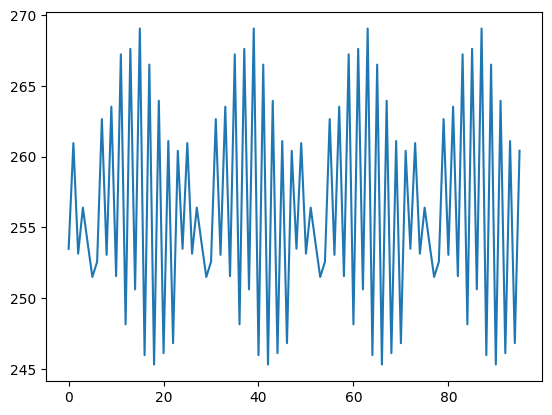

In [55]:
pos = [p[0] for p in needle_positions]
for _ in range(2):
    pos.extend(pos)

plt.plot(pos)